In [1]:
!pip install opencv-python


In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [5]:
!pwd

/Users/shashwatgupta/Library/CloudStorage/OneDrive-Personal/Stuff/Academics@IIT Kanpur/8th Semester Courses/UGP/Assingment/CV Algorithm Code/TB-Crohn


In [6]:
img_path = './Images/A.jpeg'

In [27]:
# Main ray based algorithm, which gives us broken outlines

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

blurred_image = cv2.GaussianBlur(img, (11, 11), 0)
(T, thresh) = cv2.threshold(blurred_image, 155, 255, cv2.THRESH_BINARY)

granular_degree = 0.05 # Angle between each ray (there will be 360/granular_degree rays)

def line_iter(start, end):
    """Yield coordinates on a line from start to end using Bresenham's algorithm."""
    x0, y0 = start
    x1, y1 = end
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        yield (x0, y0)
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

def process_ray(img, center, process_point_func):
    height, width = img.shape[:2]
    new_img = np.zeros((height, width, 3), dtype=np.uint8)  # Create a blank color image

    for angle in np.arange(0, 360, granular_degree):
        theta = np.deg2rad(angle)
        end_x = int(center[0] + math.cos(theta) * width)
        end_y = int(center[1] + math.sin(theta) * height)

        point_to_color, another_point = process_point_func(img, center, (end_x, end_y))
        if point_to_color:
            new_img[point_to_color[1], point_to_color[0]] = [0, 0, 255]  # Color the point red
            new_img[another_point[1], another_point[0]] = [0,255, 0]  # Color the point green

    return new_img

def find_last_point(img, start, end):
    last_black_point = None
    last_white_point = None
    answer=None
    for x, y in line_iter(start, end):
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            if img[y, x] == 0:
                last_black_point = (x, y)
            elif last_black_point and img[y, x] != 0:  # Check for a white point after the last black point
                answer=last_black_point
                last_white_point = (x, y)
    return answer, last_white_point

def convert_to_rgb_if_grayscale(img):
    if len(img.shape) == 2 or img.shape[2] == 1:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img_rgb
    else:
        return img

def convert_to_grayscale_if_rgb(img):
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img_gray
    else:
        return img

img = convert_to_grayscale_if_rgb(thresh)
center = (img.shape[1] // 2, img.shape[0] // 2)
result_img_last = process_ray(img, center, find_last_point)


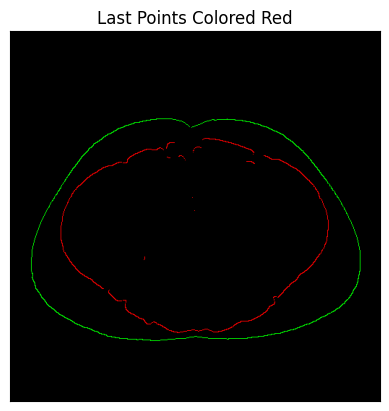

In [28]:
plt.imshow(cv2.cvtColor(result_img_last, cv2.COLOR_BGR2RGB))
plt.title('Last Points Colored Red')
plt.xticks([])
plt.yticks([])
plt.show()

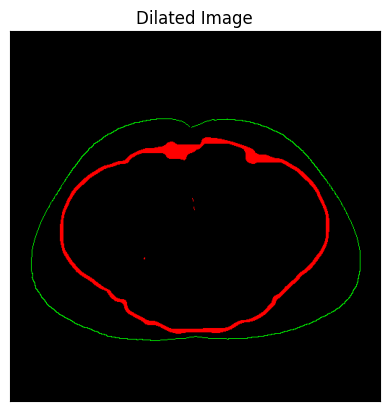

In [39]:
# Connection Cell  : dilation -> blurring -> erosion (Gaussian mediated closing morphological operation)

cycles = 9

connected_image = result_img_last
kernel = np.ones((5, 5), np.uint8)  # Example: a 5x5 square kernel
blue_channel, green_channel, red_channel = cv2.split(connected_image)

dilated_red = cv2.dilate(red_channel, kernel, iterations=cycles-1)
blurred_image = cv2.GaussianBlur(dilated_red, (21, 21), 0)
eroded_red = cv2.erode(blurred_image, kernel, iterations=cycles-2)

dilated_green = cv2.dilate(green_channel, kernel, iterations=cycles-1)
blurred_image = cv2.GaussianBlur(dilated_green, (21, 21), 0)
eroded_green = cv2.erode(blurred_image, kernel, iterations=cycles-2)

connected_image = cv2.merge([blue_channel, green_channel, eroded_red])
(T, thresh) = cv2.threshold(connected_image, 155, 255, cv2.THRESH_BINARY)


# plot the image
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.title('Dilated Image')
plt.xticks([])
plt.yticks([])
plt.show()

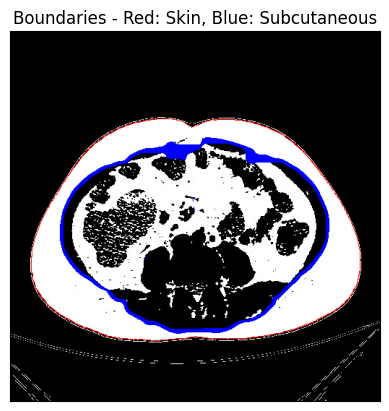

In [41]:
import cv2
import numpy as np

image_a= thresh # from above
image_b = cv2.imread(img_path)

if image_a.shape != image_b.shape:
    raise ValueError("Both images must be of the same size")

for idx,x in enumerate(image_b):
    for idy,y in enumerate(x):
        if image_a[idx][idy][0] == 0 and image_a[idx][idy][1] == 0 and image_a[idx][idy][2] == 255:
            image_b[idx][idy] = [255,0,0]
        if image_a[idx][idy][0] == 0 and image_a[idx][idy][1] == 255 and image_a[idx][idy][2] == 0:
            image_b[idx][idy] = [0,0,255]




# plot the image
plt.imshow(cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB))
plt.title('Boundaries - Red: Skin, Blue: Subcutaneous')
plt.xticks([])
plt.yticks([])
plt.show()

